<a href="https://colab.research.google.com/github/MuhammadHelmyOmar/PyTorch_Projects/blob/main/custom_datasets.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Recap

Steps to solve a machine learning problem:
1. Find a dataset
2. Turn the dataset into numbers
3. Create a model or find a pretrained one to extract the patterns in the data for prediction

# Intro

- Custom Data: a collection of data relating to your problem.
- PyTorch provides functions to load in different custom datasets in the **TorchVision**, **TorchText**, **TorchAudio**, and **TorchRec** domain libraries.
- If the previous functions are not enough, we can subclass **torch.utils.data.Dataset** and customize it to our needs.
- In this notebook, we will not use an in-built PyTorch dataset.
- We will load a custom dataset and train a model on it.



# Setting up environment

In [1]:
import torch
from torch import nn

torch.__version__

'2.6.0+cu124'

In [2]:
# Using a device-agnostic code is a best practice in DL

device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cpu'

# Setting up Data

- Start with existing data.
- We will use a subset of the [Food-101](https://data.vision.ee.ethz.ch/cvl/datasets_extra/food-101/) dataset.
- Food-101 splits to:
    - 1000 images of 101 different kinds of foods = 101,000 total images
    - 750,750 for training and 250,250 for testing
- Food-101 is included in PyTorch now.

## Formatting the custom data

- We will start with three food classes: Sushi, Pizza, and Steak.

### Data Creation

In [3]:
# import torchvision as tv
# import pathlib # Setting up data directory

# tv.__version__
# data_dir = pathlib.Path("../data")

In [4]:
# train_data = tv.datasets.Food101(root = data_dir,
#                          split = "train",
#                          download = True)

# test_data = tv.datasets.Food101(root = data_dir,
#                                 split = "test",
#                                 download = True)

In [5]:
# train_data, test_data

In [6]:
# class_names = train_data.classes
# print(len(class_names))
# class_names[:20]

In [7]:
# # View a sample image

# print(class_names[train_data[1000][1]])
# train_data[1000][0]

### Subseting appropriate classes

- Copy 10% random images of the specified classes to a separate folders.

In [8]:
# import random

In [9]:
# data_path = data_dir / "food-101" / "images"
# target_classes = ["pizza", "steak", "sushi"]

# DATA_AMOUNT = 0.1

# def get_subset(data_path,
#                data_splits = ['train', 'test'],
#                target_classes = ['pizza', 'steak', 'sushi'],
#                amount = 0.1,
#                seed = 42):

#     random.seed(seed)
#     label_splits = {}

#     for data_split in data_splits:

#         print(f"[INFO] Creating {data_split} split..")

#         label_path = data_dir / "food-101" / "meta" / f"{data_split}.txt"
#         with open(label_path, 'r') as f:
#             labels = [line.strip("\n") for line in f.readlines() if line.split("/")[0] in target_classes]

#         # Extracting a random subset
#         n_samples = round(amount * len(labels))
#         print(f"[INFO] Extracting random subset of {n_samples} images for {data_split}..")
#         sample_images = random.sample(labels, k = n_samples)

#         # Apply full path
#         image_paths = [pathlib.Path(str(data_path / sample_image) + ".jpg") for sample_image in sample_images]
#         label_splits[data_split] = image_paths

#     return label_splits

In [10]:
# label_splits = get_subset(data_path = data_path, amount = DATA_AMOUNT)
# label_splits.keys(), label_splits['test'][:14]

### Moving images to dedicated folders

In [11]:
# # Create target directory path
# target_dir_name = f"../data/pizza_steak_sushi_{str(int(DATA_AMOUNT*100))}_precent"
# print(f"Creating directory: '{target_dir_name}'")

# # Set up the directories
# target_dir = pathlib.Path(target_dir_name)
# # Make the directories
# target_dir.mkdir(parents = True, exist_ok = True)

In [12]:
# print(target_dir)

In [13]:
# import shutil # Stands for shell utilities and provides some operations on files

In [14]:
# for data_split in label_splits.keys():
#     for image_path in label_splits[str(data_split)]:
#         dest_dir = target_dir / data_split / image_path.parent.stem / image_path.name

#         if not dest_dir.parent.is_dir():
#             dest_dir.parent.mkdir(parents=True, exist_ok=True)

#         print(f"[INFO] Copying {image_path} to {dest_dir}..")
#         shutil.copy2(image_path, dest_dir) # Copyting files while preserving metadata

In [15]:
# Trace directories

def trace_dir(dir_path):
    """
    Walk through directories printing its contents.

    Args:
        dir_path (str): target directory

    Returns:
        A print out of:
            number of subdirectories in dir_path
            number of images (files) in each subdirectory
            number of each subdirectory
    """

    import os

    for subdir_path, subdir_names, file_names in os.walk(dir_path):
        print(f"There are {len(subdir_names)} and {len(file_names)} images in '{subdir_path}'")

In [16]:
# trace_dir(target_dir)

### Zipping up images folder

In [17]:
# zip_file_name = data_dir / f"pizza_steak_sushi_{str(int(DATA_AMOUNT*100))}_percent"

# shutil.make_archive(zip_file_name,
#                     format = 'zip',
#                     root_dir = target_dir)

In [18]:
# !ls -la ../data/

In [19]:
# !mkdir -p pizza_sushi_steak
# !unzip ../data/pizza_steak_sushi_10_percent.zip -d pizza_sushi_steak

In [20]:
# !ls

## Download Data

In [21]:
import requests # To deal with HTTP requests from web services and APIs
import zipfile
from pathlib import Path

In [22]:
# Setting up path to the data
data_path = Path("data/")
images_path = data_path / "pizza_steak_sushi"

if images_path.is_dir():
    print(f'{images_path} directory exists.')
else:
    print(f'{images_path} not found.. creating one..')
    images_path.mkdir(parents=True, exist_ok=True)

    # Download data
    with open(data_path / "pizza_steak_sushi.zip", "wb") as f:
        request = requests.get("https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip")
        print(f"Downloading data..")
        f.write(request.content)

    # Unzipping data
    with zipfile.ZipFile(data_path / "pizza_steak_sushi.zip", 'r') as zip_ref:
        print(f"Unzipping data..")
        zip_ref.extractall(images_path)

data/pizza_steak_sushi not found.. creating one..
Unzipping data..


- Inspect the data and think what you want to do with it.
- Image classes exist in seperate directories named after the class name.
- Turn this data into a dataset compatible with PyTorch.

In [23]:
trace_dir(dir_path = images_path)

There are 2 and 0 images in 'data/pizza_steak_sushi'
There are 3 and 0 images in 'data/pizza_steak_sushi/test'
There are 0 and 25 images in 'data/pizza_steak_sushi/test/pizza'
There are 0 and 31 images in 'data/pizza_steak_sushi/test/sushi'
There are 0 and 19 images in 'data/pizza_steak_sushi/test/steak'
There are 3 and 0 images in 'data/pizza_steak_sushi/train'
There are 0 and 78 images in 'data/pizza_steak_sushi/train/pizza'
There are 0 and 72 images in 'data/pizza_steak_sushi/train/sushi'
There are 0 and 75 images in 'data/pizza_steak_sushi/train/steak'


- The average total number of images for the test data is 25 images.
- The average total number of images for the train data is 75 images.

In [24]:
train_dir = images_path / 'train'
test_dir = images_path / 'test'

train_dir, test_dir

(PosixPath('data/pizza_steak_sushi/train'),
 PosixPath('data/pizza_steak_sushi/test'))

## Visualing Images

In [25]:
import random
from PIL import Image

random.seed(42)

Image path: data/pizza_steak_sushi/test/steak/1882831.jpg
Image class: steak
Image height: 512
Image width: 306


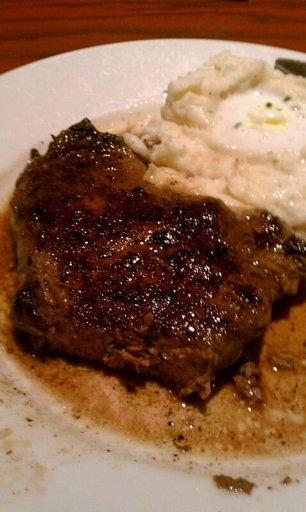

In [26]:
# Get all image paths
images_paths = list(images_path.glob("*/*/*.jpg"))

random_image_path = random.choice(images_paths)
print("Image path:", random_image_path)

image_class = random_image_path.parent.stem # The name of the directory where the image is stored
print("Image class:", image_class)

img = Image.open(random_image_path)
print("Image height:",img.height)
print("Image width:", img.width)

img

- If we want to use the **matplotlib**, we have to convert the image to a numpy array.

In [27]:
import numpy as np
import matplotlib.pyplot as plt

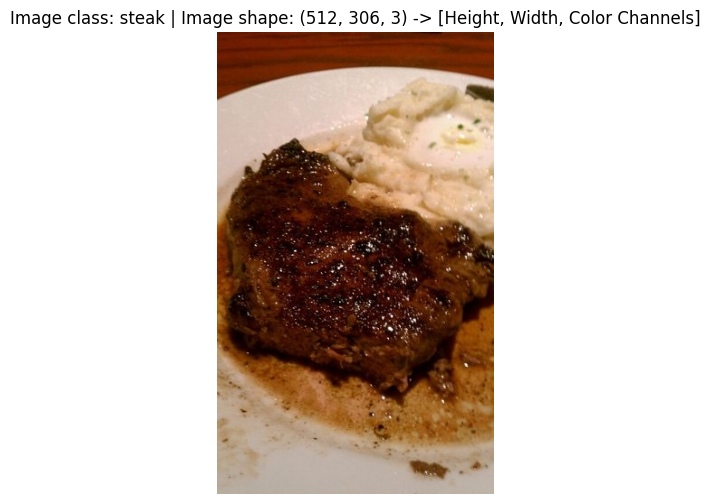

In [28]:
img_to_array = np.asarray(img)
# print(img_to_array)

plt.figure(figsize = (10, 6))
plt.imshow(img_to_array)
plt.title(f"Image class: {image_class} | Image shape: {img_to_array.shape} -> [Height, Width, Color Channels]")
plt.axis(False);

## Data Transformation

- Turn your data into Tensors (numerical representation) to be able to load it into PyTorch.
- **torchvision.transforms** have methods to format images, turning them into tensors, or manipulating them.

In [29]:
import torch
from torch.utils.data import DataLoader
import torchvision as tv # because we are dealing with a vision problem
from torchvision import transforms

In [30]:
def plot_images(images_paths,
                transform = False,
                transformer = None,
                n = 3,
                seed = 42):

    """Plot a series of random images from images_paths.
    - Opens n images from images_paths.
    - [Transforms the images (if specified)].
    - Plot the images side by side

    Args:
        images_paths (list): List of target image paths.
        transform (bool): Specify whether to plot transformed images or the originals.
        transformer (PyTorch Tranforms): Transforms to be applied to images.
        n (int): Number of images to plot.
        seed (int): Random seed for the random generator.
    """

    random.seed(seed)

    random_sample = random.sample(images_paths, k=n)

    for image_path in random_sample:
        with Image.open(image_path) as img:

            if transform:
                fig, ax = plt.subplots(1, 2)
                ax[0].imshow(img)
                ax[0].set_title(f"Original\nSize: {img.size}")
                ax[0].axis("off")

                transformed_img = transformer(img).permute(1, 2, 0)
                # permute() changes the shape of the image to suit matplotlib as the PyTorch default is [C, H, W] and matplotlib is [H, W, C]
                ax[1].imshow(transformed_img)
                ax[1].set_title(f"Transformed\nSize: {transformed_img.shape}")
                ax[1].axis("off")

            else:
                fig, ax = plt.subplots(1, 1)
                ax.imshow(img)
                # ax.set_title(f"Image\nSize: {img.size}")
                ax.axis("off")

            fig.suptitle(f"Class {image_path.parent.stem}", fontsize=12)

In [31]:
# Stack a composition of transforms

image_transformer = tv.transforms.Compose([
    # Resize the image
    tv.transforms.Resize(size = (64,64)),

    # Flip the image randomly (with parameter = p) on the horizontal
    tv.transforms.RandomHorizontalFlip(p = 0.5),

    # Turn the image into tensor
    tv.transforms.ToTensor()
])

- Note: **ToTensor()** converts all pixel values from 0 to 255 to be between 0.0 and 1.0.

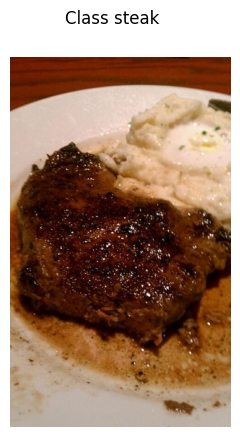

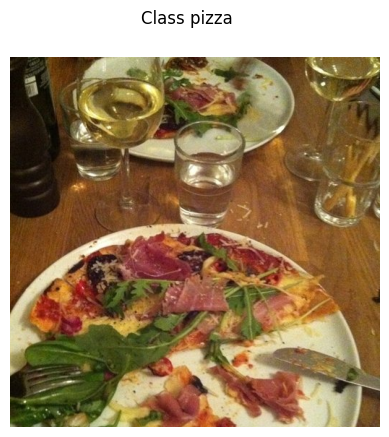

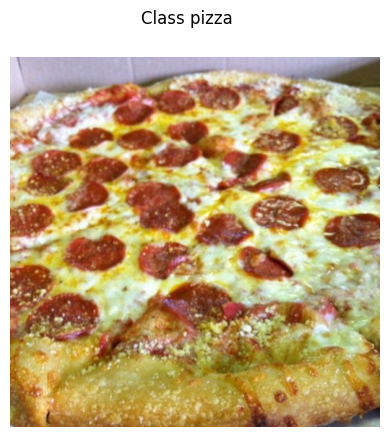

In [32]:
plot_images(images_paths = images_paths)

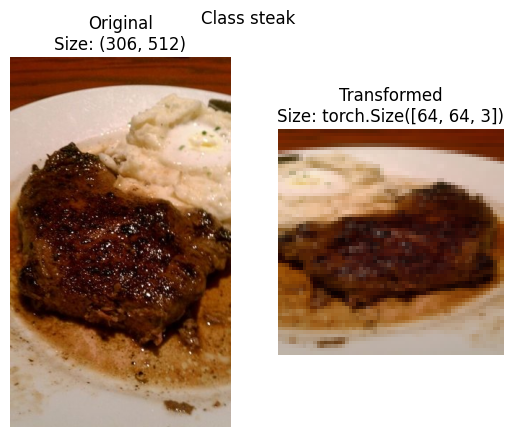

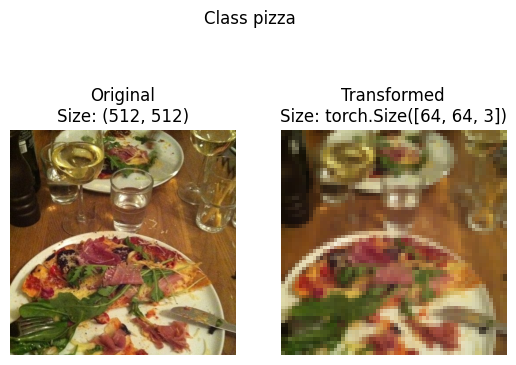

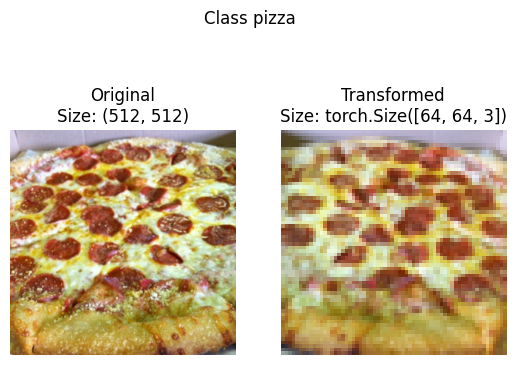

In [33]:
plot_images(images_paths = images_paths,
            transform = True,
            transformer = image_transformer)

- Large shape of an image indicates more information that the model can learn.
- We trade off between the accuracy gained from large image shape and the computational costs of such large shapes.

## Loading Image Data
- Turning image data into a Dataset compatible with PyTorch.


### 1. Using **ImageFolder**
- Helpful when our data is in standard image classification format.

In [34]:
train_data = tv.datasets.ImageFolder(root = train_dir,
                                     transform = image_transformer,
                                     target_transform = None)

test_data = tv.datasets.ImageFolder(root = test_dir,
                                    transform = image_transformer)

print(f"Train data:\n{train_data}\nTest data:\n{test_data}")

Train data:
Dataset ImageFolder
    Number of datapoints: 225
    Root location: data/pizza_steak_sushi/train
    StandardTransform
Transform: Compose(
               Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=True)
               RandomHorizontalFlip(p=0.5)
               ToTensor()
           )
Test data:
Dataset ImageFolder
    Number of datapoints: 75
    Root location: data/pizza_steak_sushi/test
    StandardTransform
Transform: Compose(
               Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=True)
               RandomHorizontalFlip(p=0.5)
               ToTensor()
           )


In [35]:
class_names, class_dict = train_data.classes, train_data.class_to_idx

print(class_names, class_dict)

['pizza', 'steak', 'sushi'] {'pizza': 0, 'steak': 1, 'sushi': 2}


In [36]:
img, label = train_data[2][0], train_data[2][1]

print(f"Image tensor:\n{img}")
print(f"Image shape: {img.shape}")
print(f"Image tensor: {img.dtype}")
print(f"Image label: {label}")
print(f"Label datatype: {type(label)}")

Image tensor:
tensor([[[0.0392, 0.0392, 0.0431,  ..., 0.2275, 0.2314, 0.2314],
         [0.0392, 0.0392, 0.0392,  ..., 0.2196, 0.2235, 0.2196],
         [0.0392, 0.0392, 0.0392,  ..., 0.2078, 0.2118, 0.2118],
         ...,
         [0.8118, 0.8078, 0.7961,  ..., 0.5373, 0.4863, 0.4039],
         [0.5176, 0.6157, 0.6392,  ..., 0.2902, 0.2000, 0.1608],
         [0.2863, 0.3333, 0.3686,  ..., 0.1216, 0.0902, 0.0784]],

        [[0.0353, 0.0353, 0.0392,  ..., 0.1922, 0.1922, 0.1922],
         [0.0353, 0.0353, 0.0353,  ..., 0.1804, 0.1843, 0.1843],
         [0.0353, 0.0353, 0.0353,  ..., 0.1765, 0.1725, 0.1765],
         ...,
         [0.5804, 0.5373, 0.5294,  ..., 0.4588, 0.4000, 0.3176],
         [0.2941, 0.3765, 0.3882,  ..., 0.2196, 0.1373, 0.1098],
         [0.1529, 0.1608, 0.1686,  ..., 0.0863, 0.0706, 0.0588]],

        [[0.0157, 0.0157, 0.0196,  ..., 0.1961, 0.2000, 0.2078],
         [0.0157, 0.0157, 0.0157,  ..., 0.1843, 0.1843, 0.1882],
         [0.0157, 0.0157, 0.0196,  ..., 0.16

Text(0.5, 1.0, 'pizza')

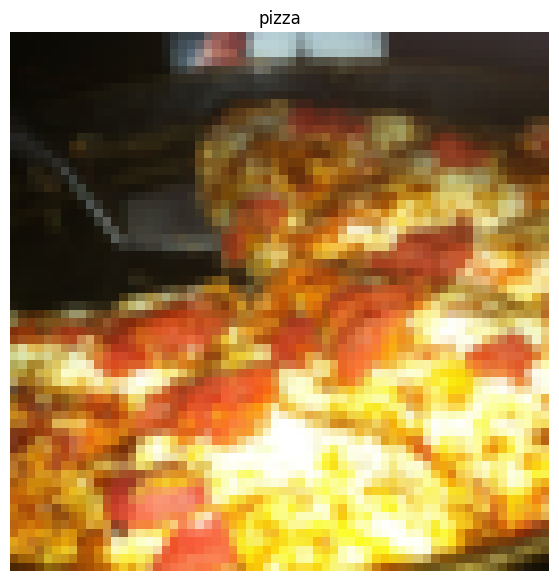

In [37]:
# Plot an image

img = img.permute(1,2,0) # Rearrange to be compatible with matplotlib

plt.figure(figsize = (10,7))
plt.imshow(img)
plt.axis("off")
plt.title(class_names[label], fontsize = 12)

- The image is blurred (not clear) because it has been resized from 512x512 to 64x64.

In [38]:
from torch.utils.data import DataLoader

In [39]:
# Turn loaded images into DataLoader to iterate over them

train_dataloader = DataLoader(dataset = train_data,
                              batch_size = 1,
                              num_workers = 1, # Number of subprocesses to be created to load the data
                              shuffle = True)

test_dataloader = DataLoader(dataset = test_data,
                             batch_size = 1,
                             num_workers = 1,
                             shuffle = False)

train_dataloader, test_dataloader

(<torch.utils.data.dataloader.DataLoader at 0x7a23a078f110>,
 <torch.utils.data.dataloader.DataLoader at 0x7a23a0496790>)

In [40]:
img, label = next(iter(train_dataloader))

print(f"Image Shape: {img.shape} -> [BCH]")
print(f"Label Shape: {label.shape}")

Image Shape: torch.Size([1, 3, 64, 64]) -> [BCH]
Label Shape: torch.Size([1])


- The higher num_workers, the more computer power PyTorch will use.

### 2. Using custom Dataset

- In case a pre-built Dataset creater as ImageFolder does not exist.
- Pros:
    - Avoid the limitation of PyTorch Dataset pre-built functions.
    - Ease in creating a Dataset of almost anything.
- Cons:
    - Writing more code which could be problematic.
    - Your custom Datset might not work.

In [41]:
import os # for dealing with directories
import pathlib # for dealing with filepaths
from torch.utils.data import Dataset # Our custom dataset class will inherit from this parent class
from typing import List, Tuple, Dict # to add type hints

In [42]:
# a helper function to get class names

def get_classes(dir: str) -> Tuple[List[str], Dict[str, int]]:
    """Gets the class folder names given a target directy.

    Assumes target directory is in standard image classification format.

    Args:
        dir (str): target directory to load classnames from.

    Returns:
        Tuple[List[str], Dict[str, int]]: (list_of_class_names, dict(class_name: idx...))

    """

    # Scan the target directory to get the class names
    classes = sorted([entry.name for entry in os.scandir(dir) if entry.is_dir()])

    # Raise and error if you did not find any classes
    if not classes:
        raise FileNotFoundError(f"The given directory does not contain any classes.")

    # Map class names into numerical labels
    class_to_idx = {class_name: i for i,class_name in enumerate(classes)}

    return classes, class_to_idx

In [43]:
get_classes(train_dir)

(['pizza', 'steak', 'sushi'], {'pizza': 0, 'steak': 1, 'sushi': 2})

- What we will create could be considered as a replication of the ImageFolder.

In [50]:
class ImageFolderCustom(Dataset): # Subclass Dataset

    def __init__(self, targ_dir:str, transform=None) -> None:

        # Initialize class atrributes

        # Get all image paths
        self.paths = list(pathlib.Path(targ_dir).glob("*/*.jpg"))

        self.transform = transform

        self.classes, self.class_to_idx = get_classes(targ_dir)

    def load_image(self, index: int) -> Image.Image:
      "Opens an image via a path and returns it."
      image_path = self.paths[index]
      return Image.open(image_path)

    # Overwriting the len
    def __len__(self):
      "Returns the total number of samples."
      return len(self.paths)

    # Overwriting the getitem
    def __getitem__(self, index:int) -> Tuple[torch.tensor, int]:
      "Returns one sample of data, data and label."
      img = self.load_image(index)
      class_name = self.paths[index].parent.name
      class_idx = self.class_to_idx[class_name]

      if self.transform:
        return self.transform(img), class_idx
      else:
        return img, class_idx

In [51]:
# Augment and transform train data

train_transforms = transforms.Compose([
    transforms.Resize((64,64)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.ToTensor()
]
)

# Transform test data (only reshaping)
test_transforms = transforms.Compose([
    transforms.Resize((64,64)),
    transforms.ToTensor()
]
)

In [52]:
# Turn data to Dataset

train_data_custom = ImageFolderCustom(targ_dir = train_dir,
                                      transform = train_transforms)

test_data_custom = ImageFolderCustom(targ_dir = test_dir,
                                     transform = test_transforms)

train_data_custom, test_data_custom

(<__main__.ImageFolderCustom at 0x7a23a06892d0>,
 <__main__.ImageFolderCustom at 0x7a23a02adf50>)

In [54]:
print(len(train_data_custom), len(test_data_custom))
print(train_data_custom.classes)
print(train_data_custom.class_to_idx)

225 75
['pizza', 'steak', 'sushi']
{'pizza': 0, 'steak': 1, 'sushi': 2}


In [55]:
len(train_data), len(test_data)

(225, 75)

##### Funtion displays random images

**If you found any bug, please send me: muhammadhelmymmo@gmail.com.**